# Table of Contents
 <p><div class="lev1 toc-item"><a href="#用代码实现马尔科夫链" data-toc-modified-id="用代码实现马尔科夫链-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>用代码实现马尔科夫链</a></div><div class="lev2 toc-item"><a href="#示意代码" data-toc-modified-id="示意代码-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>示意代码</a></div><div class="lev2 toc-item"><a href="#使用库函数" data-toc-modified-id="使用库函数-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>使用库函数</a></div><div class="lev1 toc-item"><a href="#平稳分布-Stationary-Distributions" data-toc-modified-id="平稳分布-Stationary-Distributions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>平稳分布 Stationary Distributions</a></div><div class="lev1 toc-item"><a href="#极限分布" data-toc-modified-id="极限分布-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>极限分布</a></div>

# 用代码实现马尔科夫链

全文约定：转移概率矩阵P的第 ***i*** 行的每个元素，表示从第 ***i*** 个状态迁移到状态空间中其他状态的概率，即:
 <big> $$P_{ij}=P(x_i, x_j)=P\{X_{t+1} = x_j | X_t = x_i\}， 其中  (x_i, x_j ∈ S)， S为状态空间$$ </big>

## 示意代码

In [1]:
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

In [6]:
def mc_sample(P, init=0, sample_size=1000):
    # === 转成 NumPy 矩阵 === #
    P = np.asarray(P)
    # === allocate memory === #
    X = np.empty(sample_size, dtype=int)
    X[0] = init
    
    # == 把初始转移概率矩阵P的每一行都转换为一个离散分布（Discrete distribution） == #
    # == 则P_dist的每个元素 i，分别表示状态 i 的转移概率分布
    n = len(P)
    P_dist = [qe.DiscreteRV(P[i,:]) for i in range(n)]

    # == 根据P_dist中状态 i 的概率分布，随机选择下一个状态，填充到结果X中 == #
    for t in range(sample_size - 1):
        X[t+1] = P_dist[X[t]].draw()

    return X

In [9]:
P = [[0.4, 0.6], [0.2, 0.8]]
X = mc_sample(P, sample_size=10)
print(X)

[0 1 0 1 1 1 0 1 1 1]


## 使用库函数

In [10]:
mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=10)
print(X)

[1 1 1 0 1 1 0 1 1 0]


In [11]:
# 有具体名称的状态
mc = qe.MarkovChain(P, state_values=('employed', 'unemployed'))
X = mc.simulate(ts_length=4, init='employed')
print(X)

['employed' 'employed' 'unemployed' 'unemployed']


# 平稳分布 Stationary Distributions
若转移概率矩阵为P，其平稳分布 ***V***满足：
$$V = VP $$

平稳分布的计算，可以用：
- 迭代法
- 特征向量（特征值为1的特征向量）
- 代数计算

下面通过画图直观的感受一下转移矩阵随着迭代趋近于平稳分布。

In [12]:
from mpl_toolkits.mplot3d import Axes3D

In [15]:
def simStationaryDist():
    P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))
    P = np.array(P)
    
    psi = (0.0, 0.2, 0.8)        # 初始分布
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
#     ax.set_xticks((0.25, 0.5, 0.75))
#     ax.set_yticks((0.25, 0.5, 0.75))
#     ax.set_zticks((0.25, 0.5, 0.75))

    x_vals, y_vals, z_vals = [], [], []
    for t in range(20):
        x_vals.append(psi[0])
        y_vals.append(psi[1])
        z_vals.append(psi[2])
        psi = np.dot(psi, P)

    ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)

    mc = qe.MarkovChain(P)
    psi_star = mc.stationary_distributions[0]
    ax.scatter(psi_star[0], psi_star[1], psi_star[2], c='k', s=60)

    plt.show()

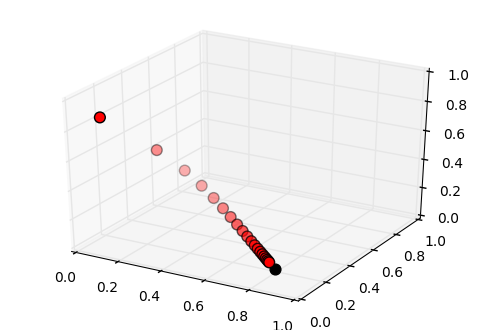

In [16]:
simStationaryDist()

# 极限分布

对一个不可约性的Markov过程，当 $n \to \infty$ 时，满足：
$$ \frac{1}{n}\sum_{t=1}^{n}1\{X_t = x\} \to V(x) $$

- $ 1\{X_t = x\} $ 表示当 $X_t$ == x 时取值为1，否则取值为0
- 该极限必然存在，且平稳分布就是一个合法的极限

下面用一个实际的例子，画图来直观感受一下。

假设一个Markov过程有两个状态{1, 2}, 其转移概率矩阵为：

  $$ P = \left( \begin{array}{cc}
1-a & a \\
b & 1-b \end{array} \right) $$
  
可以计算得到状态 1 的稳定分布为：
  $$ V_1 = \frac{b}{a + b} $$

不妨取 a = b = 0.1。计算随着迭代次数增加，状态 1 的极限分布和平稳分布的差值变化情况，并画图。

In [24]:
def simDiff():
    a = b = 0.1
    N = 10000
    v1 = b / (a + b)

    P = ((1 - a, a),
         (b, 1 - b))
    P = np.array(P)
    mc = MarkovChain(P)
    
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_ylim(-0.25, 0.25)
    ax.grid()
    ax.hlines(0, 0, N, lw=2, alpha=0.6)  # Horizonal line at zero

    for x0, col in ((0, 'blue'), (1, 'green')):
        # == 用初始状态 x0 生成一个Markov序列 == #
        X = mc.simulate(N, init=x0)
        
        # == 根据极限分布公式得到序列 == #
        X_bar = (X == 0).cumsum() / (1 + np.arange(N, dtype=float)) 
        
        # == Plot == #
        ax.fill_between(range(N), np.zeros(N), X_bar - v1, color=col, alpha=0.1)
        ax.plot(X_bar - v1, color=col, label=r'$X_0 = \, {} $'.format(x0))
        ax.plot(X_bar - v1, 'k-', alpha=0.6)  # Overlay in black--make lines clearer

    ax.legend(loc='upper right')

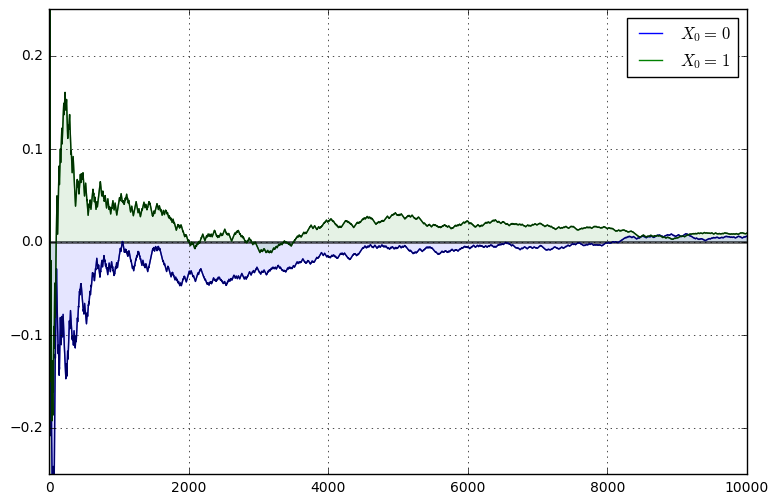

In [25]:
simDiff()